In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import urllib
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10

In [5]:
source=urllib.request.urlopen('https://www.exchangerates.org.uk/USD-INR-exchange-rate-history.html')
html=source.read()

In [6]:
soup = BeautifulSoup(html,"lxml")
#(soup.prettify())
soup.a

<a href="/" title="Exchange Rates">Exchange Rates</a>

In [7]:
data_table=soup.find('table',{"id":'hist'})
print (data_table)

<table cellpadding="3" cellspacing="0" id="hist" style="width:100%">
<tr><td colspan="2">Table of 1 US Dollar to Indian Rupee Exchange Rate:</td><td align="right"><i>Updated: 06/05/18 23:14</i></td></tr>
<tr>
<th>Date</th>
<th>US Dollar to Indian Rupee</th>
<th>Link</th>
</tr>
<tr class="colone"><td>Saturday  5 May 2018</td><td>1 USD = 66.8208 INR</td><td><a href="/USD-INR-05_05_2018-exchange-rate-history.html">USD INR rate for 05/05/2018</a></td></tr><tr class="coltwo"><td>Friday  4 May 2018</td><td>1 USD = 66.8203 INR</td><td><a href="/USD-INR-04_05_2018-exchange-rate-history.html">USD INR rate for 04/05/2018</a></td></tr><tr class="colone"><td>Thursday  3 May 2018</td><td>1 USD = 66.6701 INR</td><td><a href="/USD-INR-03_05_2018-exchange-rate-history.html">USD INR rate for 03/05/2018</a></td></tr><tr class="coltwo"><td>Wednesday  2 May 2018</td><td>1 USD = 66.8117 INR</td><td><a href="/USD-INR-02_05_2018-exchange-rate-history.html">USD INR rate for 02/05/2018</a></td></tr><tr class="

In [8]:
day=[]
rate=[]

for counter,row in enumerate(data_table.findAll('tr')):
    cells=row.findAll('td')
    if len(cells)==3:
        day.append(((cells[0].find(text=True)).split(None,1))[1])
        rate.append(float(((cells[1].find(text=True)).split(' '))[3]))

In [9]:
date=[]
print (day)
for counter,object_ in enumerate(day):
    date.append(pd.datetime.strptime(object_, "%d %B %Y"))

['5 May 2018', '4 May 2018', '3 May 2018', '2 May 2018', '1 May 2018', '30 April 2018', '29 April 2018', '28 April 2018', '27 April 2018', '26 April 2018', '25 April 2018', '24 April 2018', '23 April 2018', '22 April 2018', '21 April 2018', '20 April 2018', '19 April 2018', '18 April 2018', '17 April 2018', '16 April 2018', '15 April 2018', '14 April 2018', '13 April 2018', '12 April 2018', '11 April 2018', '10 April 2018', '9 April 2018', '8 April 2018', '7 April 2018', '6 April 2018', '5 April 2018', '4 April 2018', '3 April 2018', '2 April 2018', '1 April 2018', '31 March 2018', '30 March 2018', '29 March 2018', '28 March 2018', '27 March 2018', '26 March 2018', '25 March 2018', '24 March 2018', '23 March 2018', '22 March 2018', '21 March 2018', '20 March 2018', '19 March 2018', '18 March 2018', '17 March 2018', '16 March 2018', '15 March 2018', '14 March 2018', '13 March 2018', '12 March 2018', '11 March 2018', '10 March 2018', '9 March 2018', '8 March 2018', '7 March 2018', '6 Mar

In [10]:
rate_data=pd.DataFrame({'Day':date,'Rate':rate})
rate_data=rate_data.set_index('Day')
rate_data_full=rate_data.reindex(index=rate_data.index[::-1])
rate_data=rate_data_full[:-20]

In [11]:
rate_data.loc['20180101':'20180119'].describe()

,Rate
count,19.000000
mean,63.608505
std,0.217958
min,63.296500
25%,63.448250
50%,63.598600
75%,63.801200
max,64.018600


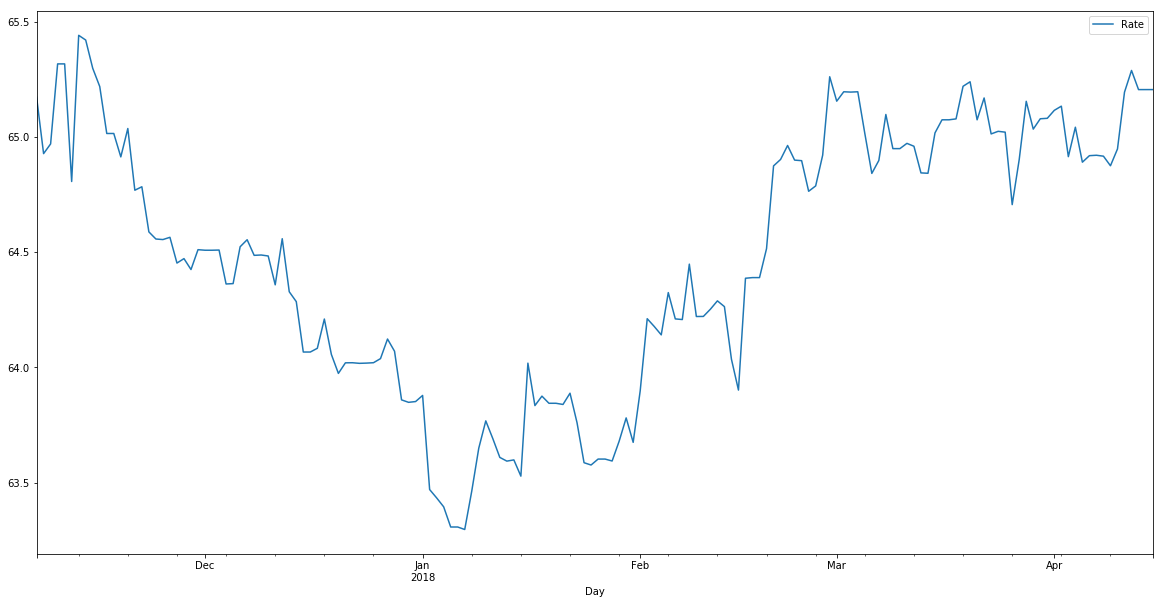

In [12]:
%matplotlib inline
plt.rcParams["figure.figsize"] = fig_size
rate_data.plot()

## Stationarity

Dickey-Fuller test for stationarity

In [13]:
df_test = adfuller(rate_data['Rate'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -1.647052
p-value                          0.458578
#Lags Used                       0.000000
Number of Observations Used    159.000000
Critical Value (1%)             -3.472161
Critical Value (5%)             -2.879895
Critical Value (10%)            -2.576557
dtype: float64


## Introducing stationarity

### 1. Difference between data and moving average

Plot rolling mean (Moving Average)

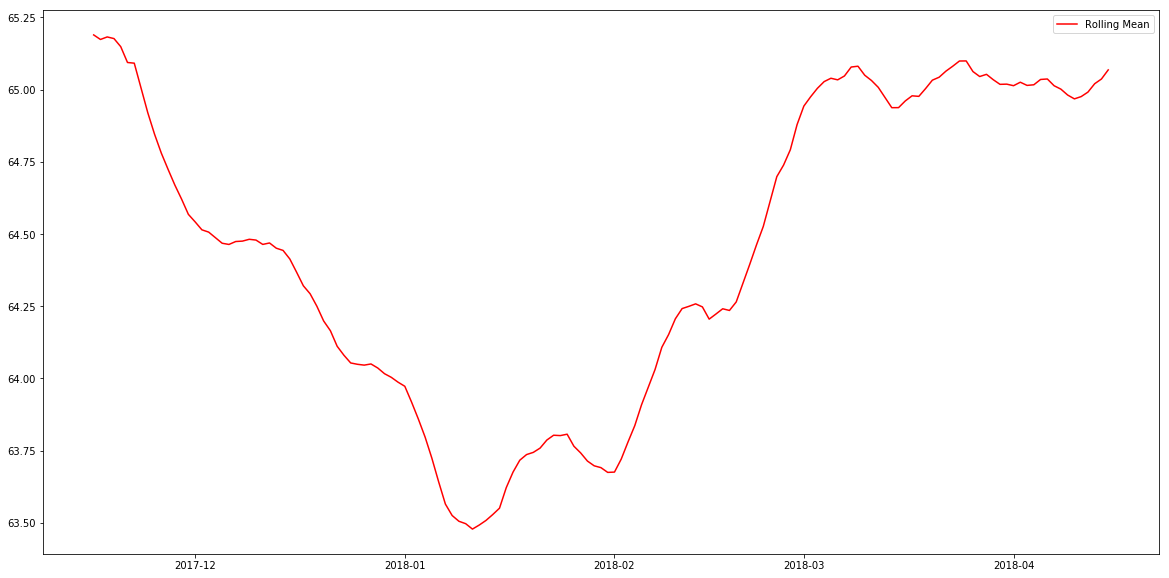

In [14]:
rolling_mean = pd.Series.rolling(rate_data['Rate'],window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
#rate_data.plot()
rmean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.show()

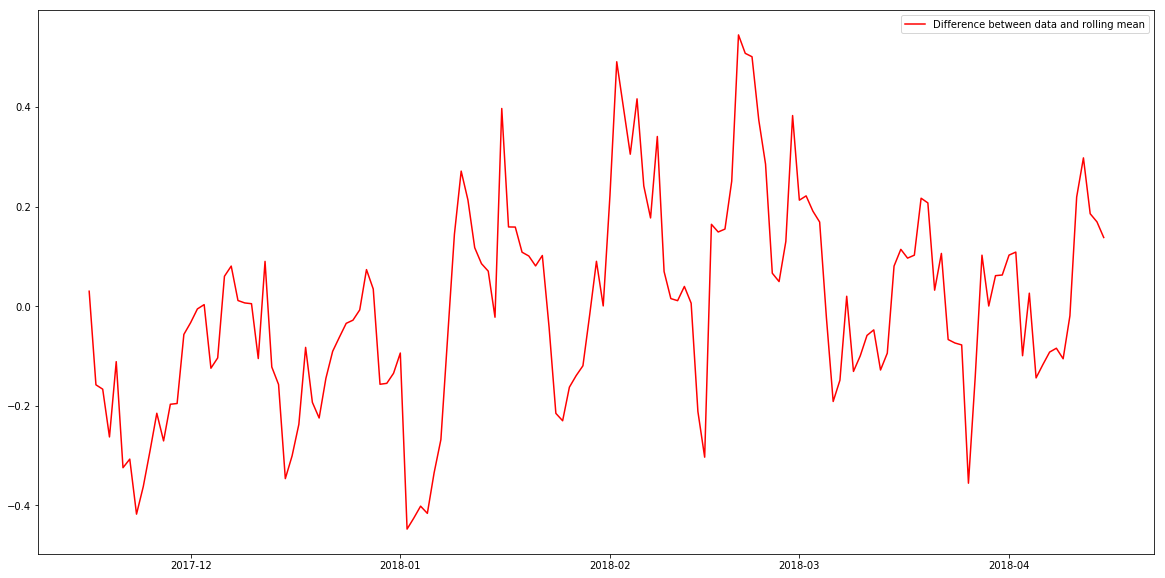

In [15]:
rolling_mean_diff=rate_data['Rate']-rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
plt.plot(rolling_mean_diff, color='red',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.show()
rolling_mean_diff.dropna(inplace=True)

In [16]:
df_test_rmean_diff = adfuller(rolling_mean_diff, autolag='AIC')
result_rmean_diff = pd.Series(df_test_rmean_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_rmean_diff[4].items():
    result_rmean_diff['Critical Value (%s)'%key] = value
print (result_rmean_diff)

Test Statistic                  -3.995505
p-value                          0.001434
#Lags Used                       0.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


### 2. Moving average of log(data)

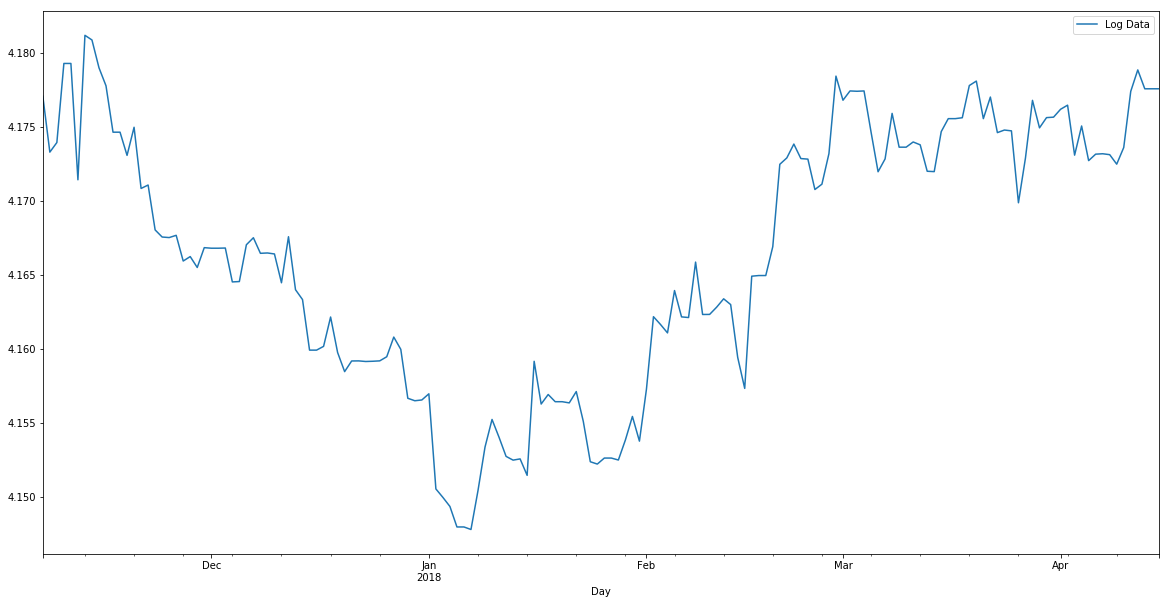

In [17]:
rate_data_log=np.log(rate_data['Rate'])
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.show()

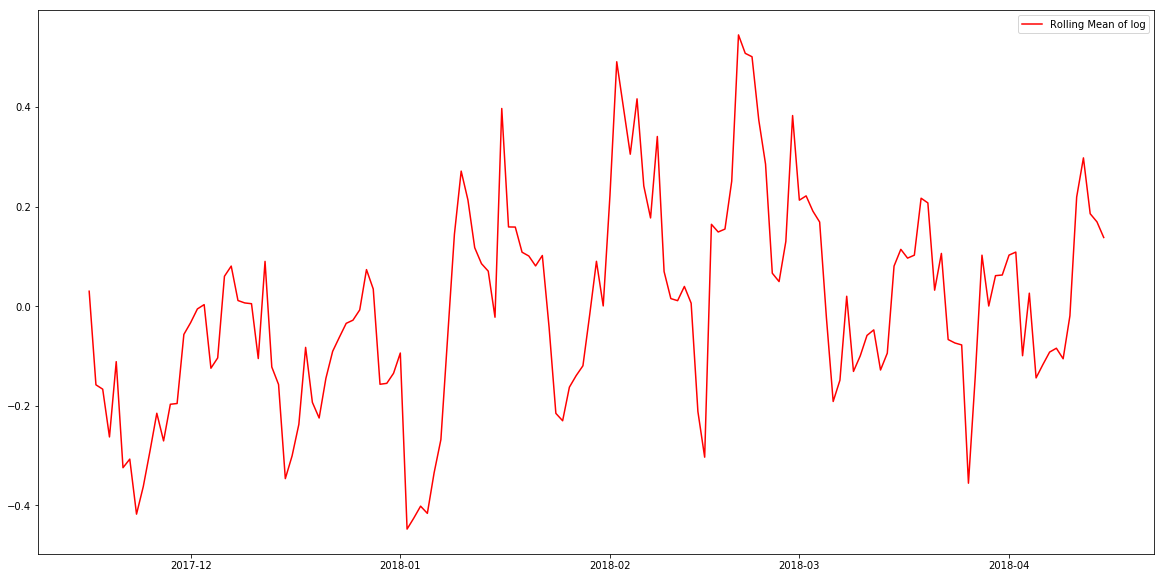

In [18]:
log_rolling_mean=pd.Series.rolling(rate_data_log,window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
log_rolmean_diff=rate_data_log-log_rolling_mean
log_rmean_diff= plt.plot(rolling_mean_diff, color='red', label='Rolling Mean of log')
plt.legend(loc='best')
plt.show()
log_rolmean_diff.dropna(inplace=True)

In [19]:
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                  -3.992886
p-value                          0.001448
#Lags Used                       0.000000
Number of Observations Used    150.000000
Critical Value (1%)             -3.474715
Critical Value (5%)             -2.881009
Critical Value (10%)            -2.577151
dtype: float64


### 3. Exponentially Weighted Moving Average of Log

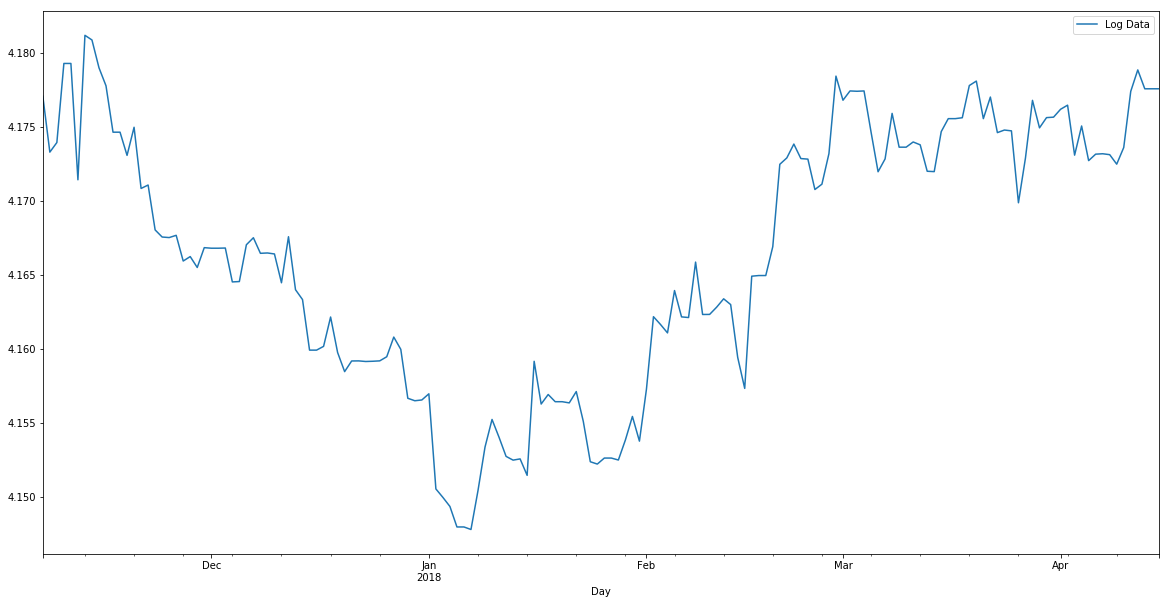

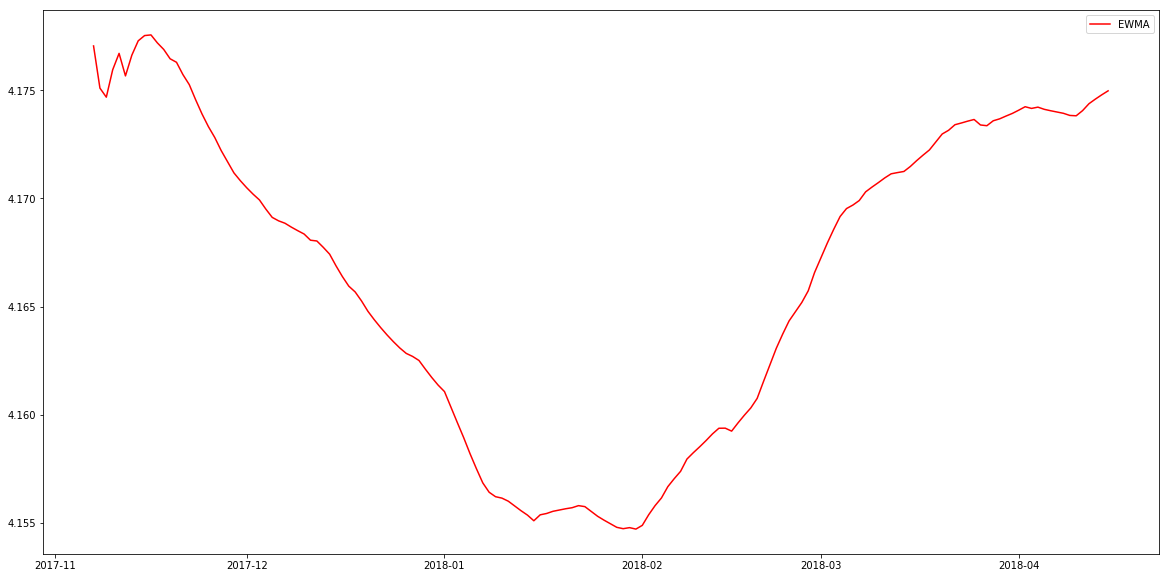

In [20]:
ewma_data=pd.Series.ewm(rate_data_log,halflife=10,min_periods=0,adjust=True,ignore_na=False).mean()
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.show()
plt.plot(ewma_data, color='red',label='EWMA')
plt.legend()
plt.legend(loc='best')
plt.show()

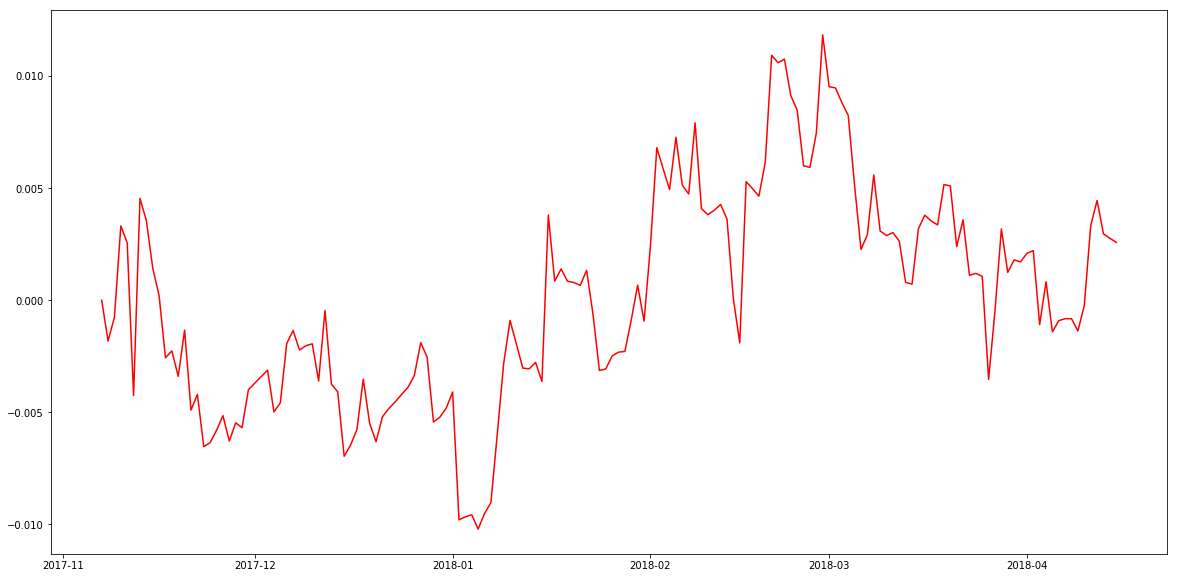

In [21]:
ewma_diff=rate_data_log-ewma_data
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ewma_diff, color='red')

In [22]:
df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                  -2.912397
p-value                          0.043925
#Lags Used                       0.000000
Number of Observations Used    159.000000
Critical Value (1%)             -3.472161
Critical Value (5%)             -2.879895
Critical Value (10%)            -2.576557
dtype: float64


### 4. First order differencing

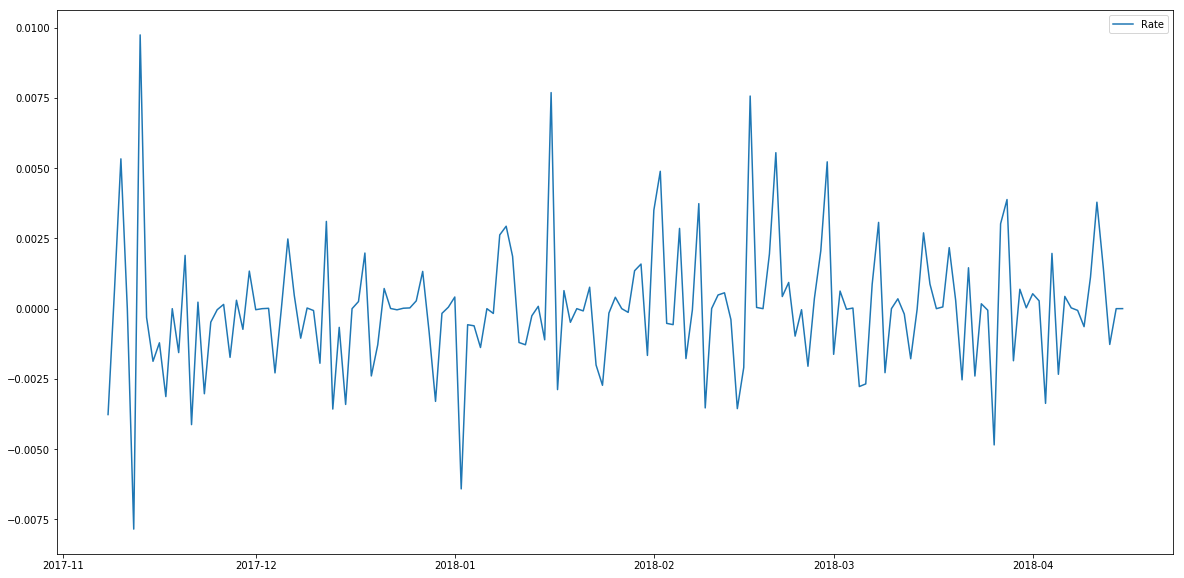

In [23]:
rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.show()

In [24]:
df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                -1.476386e+01
p-value                        2.379318e-27
#Lags Used                     0.000000e+00
Number of Observations Used    1.580000e+02
Critical Value (1%)           -3.472431e+00
Critical Value (5%)           -2.880013e+00
Critical Value (10%)          -2.576619e+00
dtype: float64


### 5. Decomposition (Trend+Seasonal+Residual)

In [25]:
rate_data_log=np.log(rate_data['Rate'])
decomposition = seasonal_decompose(rate_data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

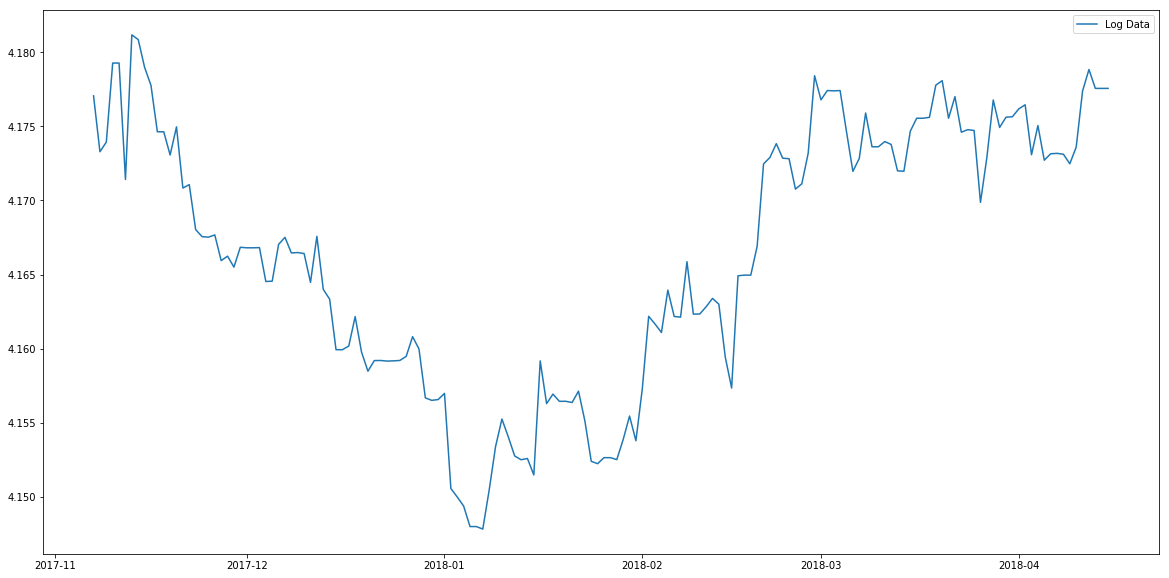

In [26]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_data_log,label='Log Data')
plt.legend()
plt.show()

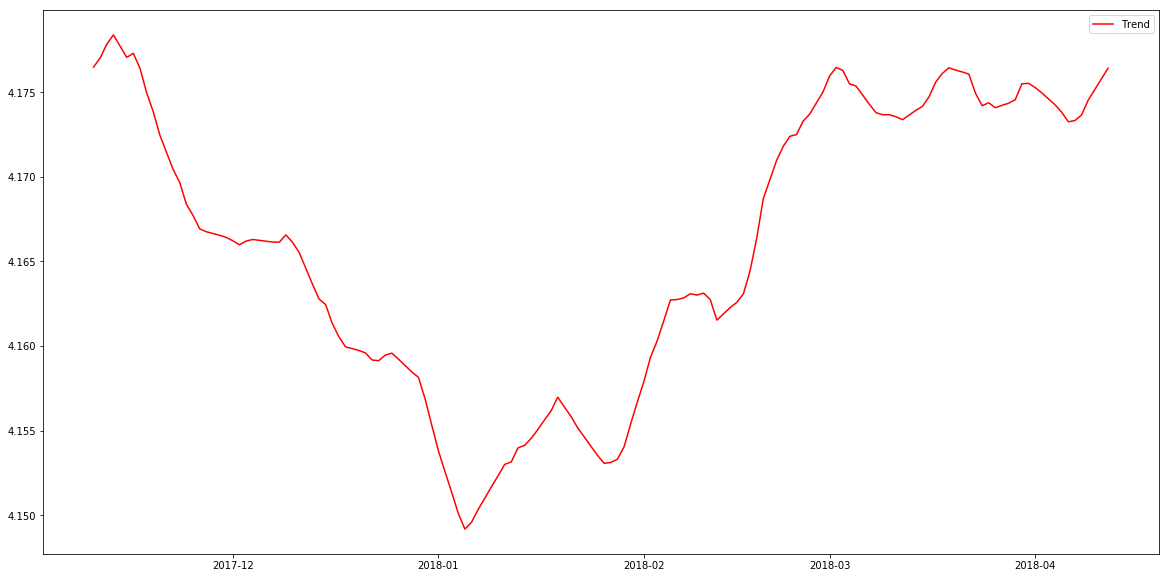

In [27]:
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.show()

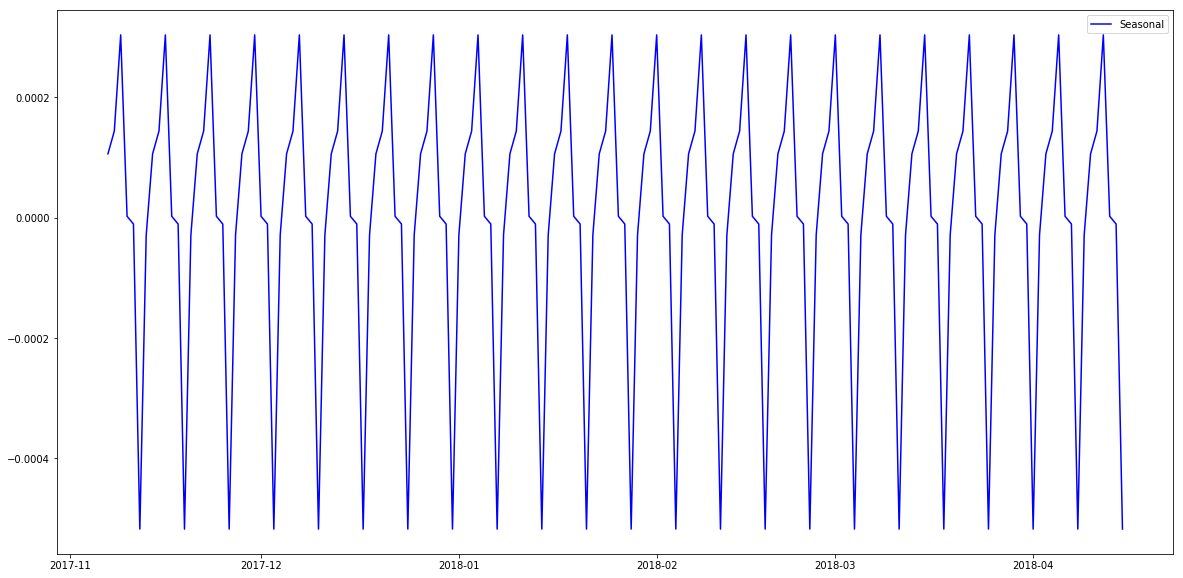

In [28]:
plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.show()

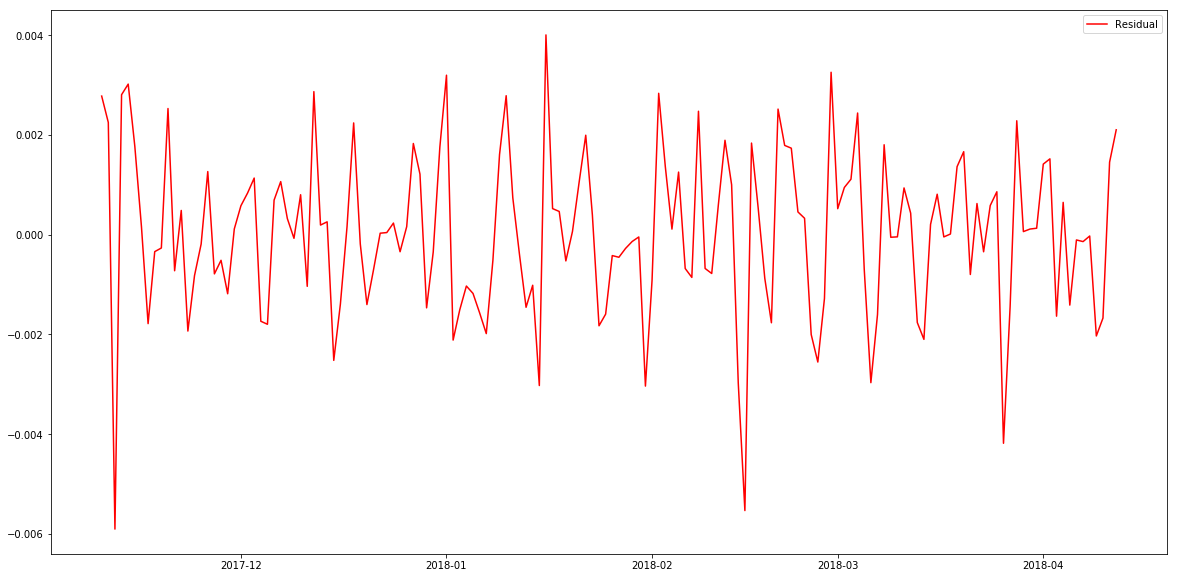

In [29]:
plt.plot(resid,color='red',label='Residual')
plt.legend()
plt.show()

In [30]:
resid.dropna(inplace=True)

df_test_resid = adfuller(resid, autolag='AIC')
result_resid = pd.Series(df_test_resid[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_resid[4].items():
    result_resid['Critical Value (%s)'%key] = value
print (result_resid)

Test Statistic                -6.394210e+00
p-value                        2.070011e-08
#Lags Used                     8.000000e+00
Number of Observations Used    1.450000e+02
Critical Value (1%)           -3.476273e+00
Critical Value (5%)           -2.881688e+00
Critical Value (10%)          -2.577513e+00
dtype: float64


### Comparison of Test Statistic

In [31]:
compare=pd.DataFrame({'Test Statistic':[result_rmean_diff.iloc[0],result_log.iloc[0],result_ewma.iloc[0],result_logdiff.iloc[0],result_resid.iloc[0]]})
Methods=['Data Rolling mean','Log Data Rolling Mean','Log EWMA','First Order Differencing','Seasonal Decomposition']
compare['Methods']=Methods
compare=compare.set_index('Methods')
compare

,Test Statistic
Methods,
Data Rolling mean,-3.995505
Log Data Rolling Mean,-3.992886
Log EWMA,-2.912397
First Order Differencing,-14.763855
Seasonal Decomposition,-6.394210


## Forecast

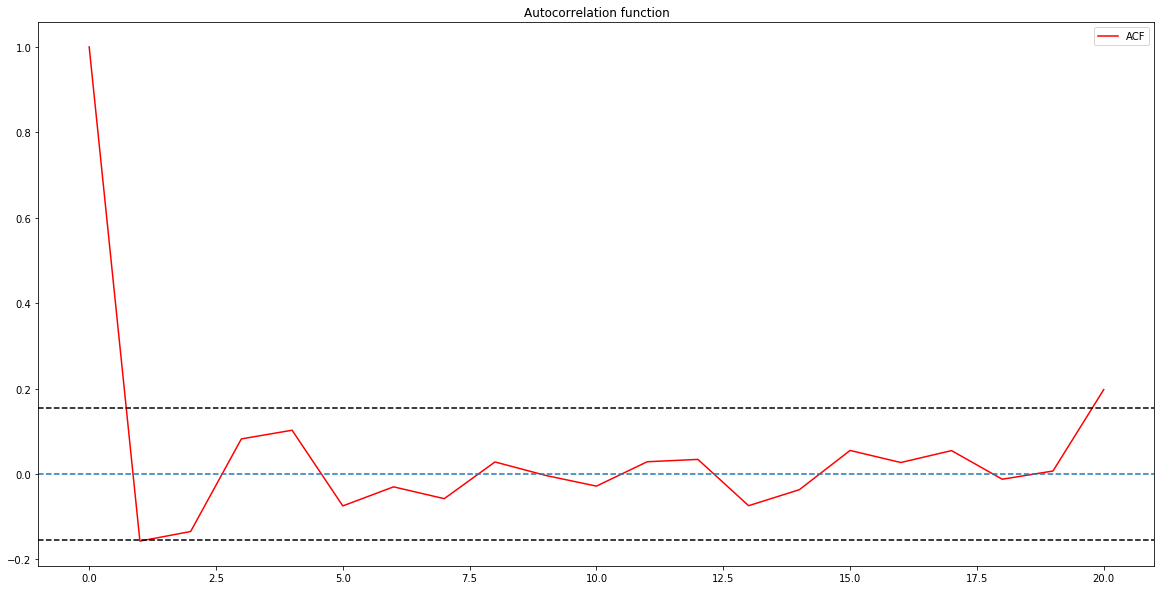

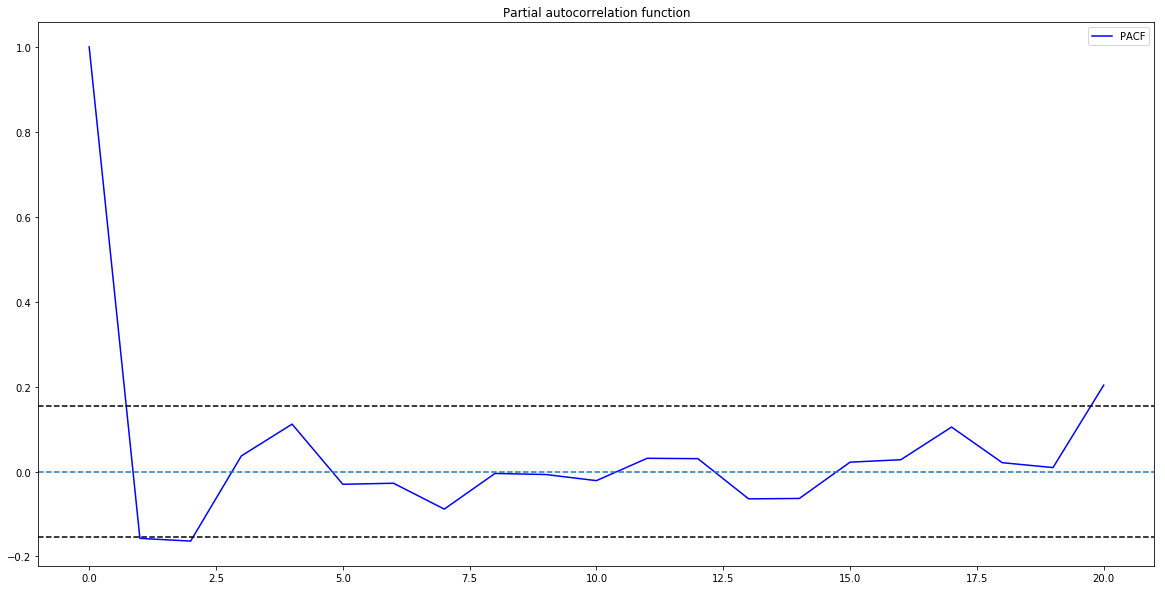

In [32]:
acf_=acf(rate_log_diff.as_matrix(columns=None),nlags=20)
pacf_ = pacf(rate_log_diff.as_matrix(columns=None), nlags=20, method='ols')

plt.plot(acf_,label='ACF',color='red')
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(rate_data_log)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(rate_data_log)),linestyle='--',color='black')
plt.title('Autocorrelation function')
plt.legend()
plt.show()

plt.plot(pacf_,label='PACF',color='blue')
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(rate_data_log)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(rate_data_log)),linestyle='--',color='black')
plt.title('Partial autocorrelation function')
plt.legend()
plt.show()

### 1. Autoregression (AR (1)) Model

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS=  nan')

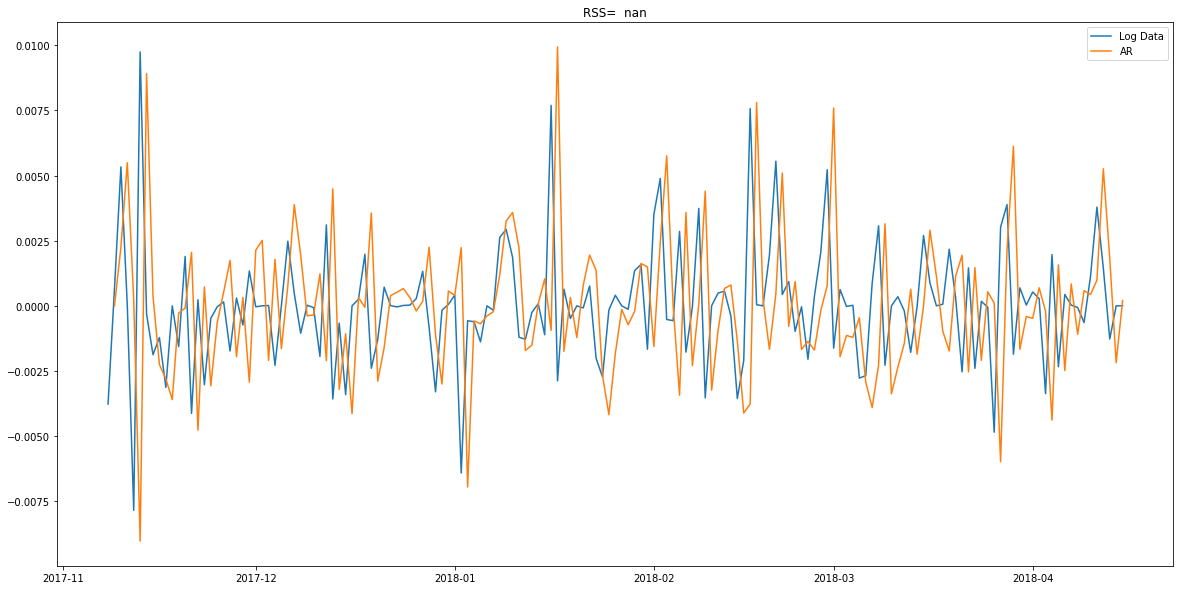

In [33]:
p=20
d=1
q=0

ar_model=ARIMA(rate_log_diff,order=(p,d,q))
ar_params=ar_model.fit(disp=-1)
RSS=sum((rate_log_diff-ar_params.fittedvalues)**2)

plt.plot(rate_log_diff,label='Log Data')
plt.plot(-ar_params.fittedvalues,label='AR')
plt.legend()
plt.title('RSS= {0:4f}'.format(RSS))

### 2. Moving Average (MA(1)) Model


C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS=        nan')

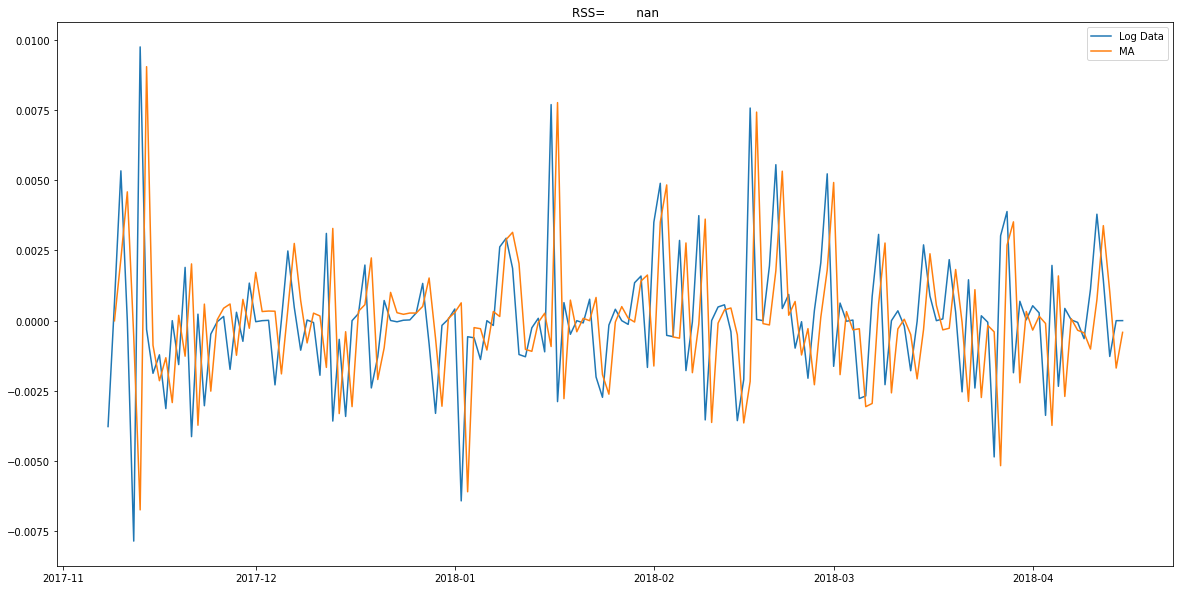

In [34]:
p=0
d=1
q=1

ma_model=ARIMA(rate_log_diff,order=(p,d,q))
ma_params=ma_model.fit(disp=-1)

RSS=sum((rate_log_diff-ma_params.fittedvalues)**2)

plt.plot(rate_log_diff,label='Log Data')
plt.plot(-ma_params.fittedvalues,label='MA')
plt.legend()
plt.title('RSS= {0:10f}'.format(RSS))

### 3. Autoregression Integrated Moving Average (ARIMA(1,1,1)) Model

In [35]:
# p=2
# d=1
# q=2

# arima_model=ARIMA(rate_data_log,order=(p,d,q))
# arima_params=arima_model.fit(disp=-1)
# arima_params.fittedvalues.dropna(inplace=True)
# RSS=sum((rate_log_diff-arima_params.fittedvalues)**2)

# plt.plot(rate_log_diff,label='Log Data')
# plt.plot(-arima_params.fittedvalues,label='ARIMA')
# plt.legend()
# plt.title('RSS= {0:4f}'.format(RSS))

In [36]:
# predictions = pd.Series(-arima_params.fittedvalues, copy=True)

In [37]:
# predictions_cumsum = predictions.cumsum()

In [38]:
# predictions_log = pd.Series(rate_data_log.iloc[0], index=rate_data_log.index)
# predictions_log = predictions_log.add(predictions_cumsum,fill_value=0)

In [39]:
# predicted_values=np.exp(predictions_log)
# plt.plot(rate_data)
# plt.plot(predicted_values)

In [40]:
# fore = arima_params.forecast(20)

In [41]:
# plt.plot(np.array(rate_data_full[len(rate_data_full)-20:]),label='Actual')
# plt.plot(fore[0],label='Forecast')
# plt.legend()

In [42]:
# ts_log = rate_data_log
# ts_log_diff = rate_log_diff

In [43]:
# model = ARIMA(ts_log, order=(2, 1, 2))  
# results_ARIMA = model.fit(disp=-1)  
# plt.plot(ts_log_diff)
# plt.plot(-results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))



In [44]:
# predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# print (predictions_ARIMA_diff.head())

In [45]:
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# print (predictions_ARIMA_diff_cumsum.head())

In [46]:
# predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions_ARIMA_log.head()

In [47]:
# plt.plot(ts_log)
# plt.plot(predictions_ARIMA_log)

In [48]:
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
# plt.plot(rate_data)
# plt.plot(predictions_ARIMA)
# #plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-rate_data)**2)/len(ts)))

### ARIMA directly on data

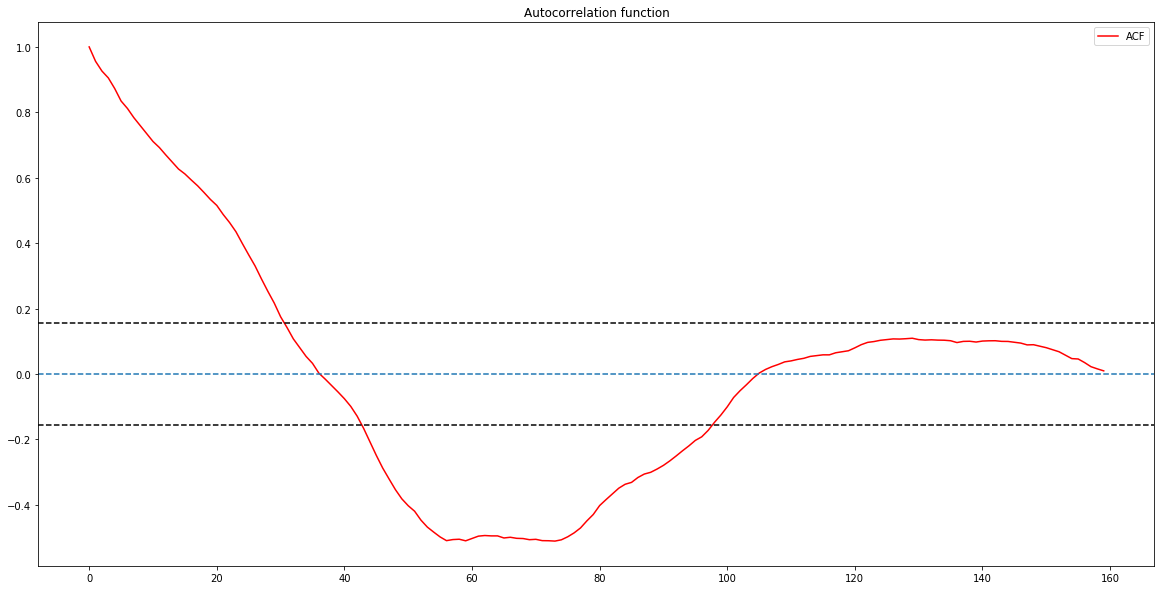

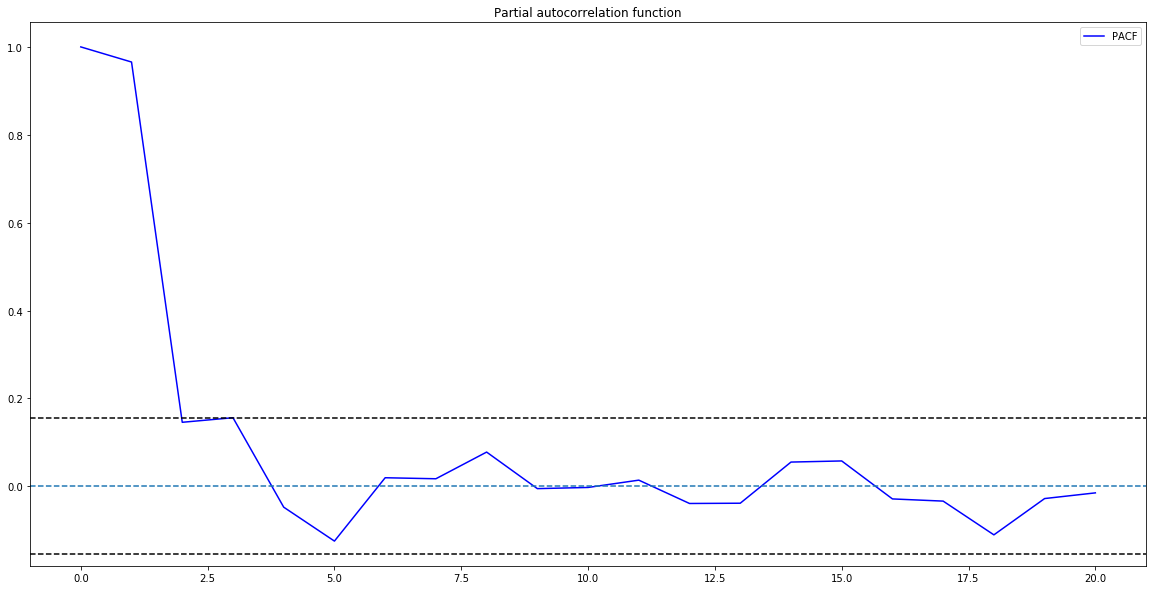

In [49]:
acf_=acf(rate_data.as_matrix(columns=None),nlags=200)
pacf_ = pacf(rate_data.as_matrix(columns=None), nlags=20, method='ols')

plt.plot(acf_,label='ACF',color='red')
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(rate_data)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(rate_data)),linestyle='--',color='black')
plt.title('Autocorrelation function')
plt.legend()
plt.show()

plt.plot(pacf_,label='PACF',color='blue')
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(rate_data)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(rate_data)),linestyle='--',color='black')
plt.title('Partial autocorrelation function')
plt.legend()
plt.show()

In [70]:
p=9
d=0
q=9

arima_model=ARIMA(rate_data,order=(p,d,q),freq='D')
arima_params=arima_model.fit(disp=-1)
arima_params.fittedvalues.dropna(inplace=True)
ans = arima_params.fittedvalues
#RSS=sum((rate_data-arima_params.fittedvalues)**2)

#plt.title('RSS= {0:4f}'.format(RSS))

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [71]:
df2=ans[1:]

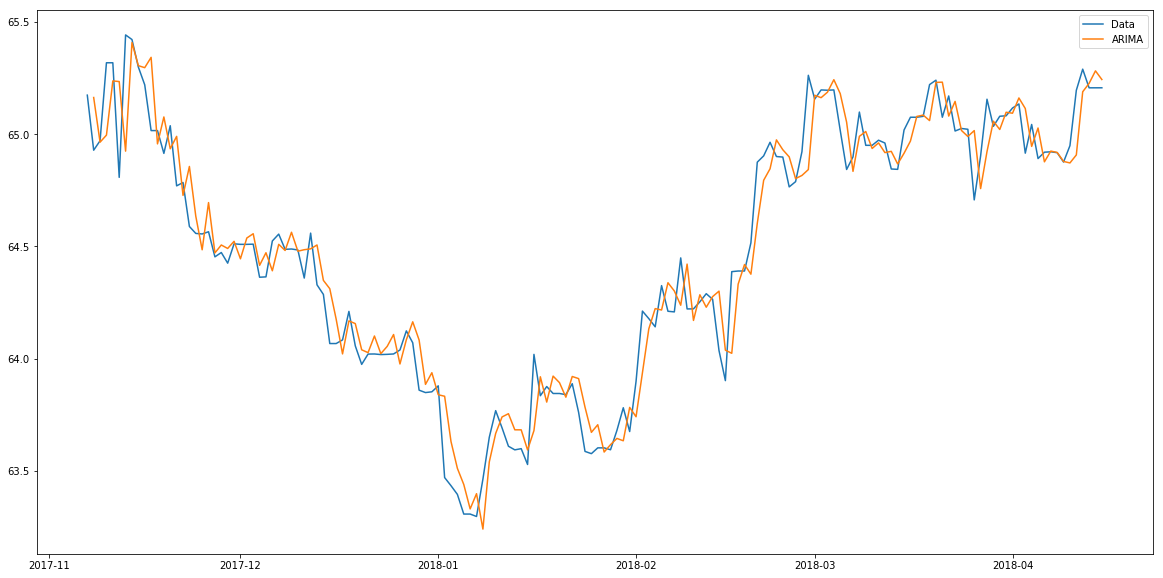

In [72]:
plt.plot(rate_data,label='Data')
plt.plot(df2,label='ARIMA')
plt.legend()

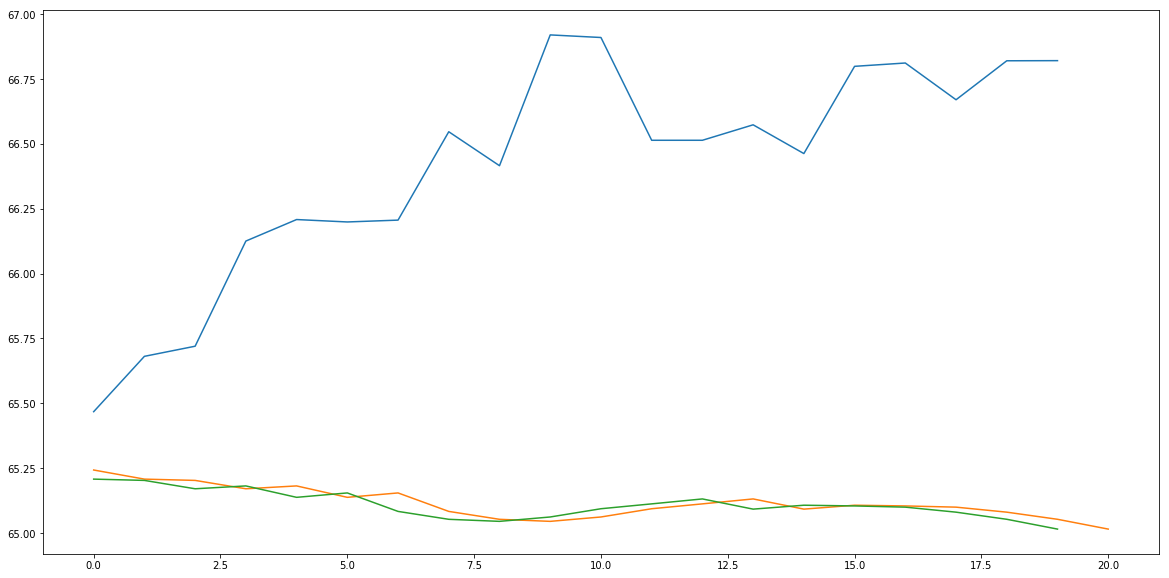

In [73]:
fore = arima_params.predict(start='2018-04-15',end='2018-05-05')
plt.plot(np.array(rate_data_full[160:]))
plt.plot(np.array(fore))
plt.plot(arima_params.forecast(20)[0])
plt.show()

In [54]:
params=arima_params.params

In [55]:
hist_p = (np.array(rate_data[-9:]))

In [56]:
np.dot(np.array(params[1:]),hist_p)

array([ 63.27098895])

In [65]:
np.array(fore)

array([ 65.24110099,  65.19289287,  65.1552214 ,  65.12961507,
        65.12325366,  65.12192863,  65.10713611,  65.09887533,
        65.09581342,  65.0918719 ,  65.08431181])

In [74]:
rate_data.index

DatetimeIndex(['2017-11-07', '2017-11-08', '2017-11-09', '2017-11-10',
               '2017-11-11', '2017-11-12', '2017-11-13', '2017-11-14',
               '2017-11-15', '2017-11-16',
               ...
               '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09',
               '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13',
               '2018-04-14', '2018-04-15'],
              dtype='datetime64[ns]', name='Day', length=160, freq=None)

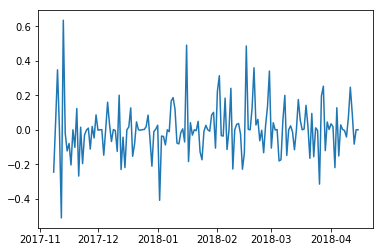

In [85]:
somedata =(rate_data-rate_data.shift())
somedata.dropna(inplace=True)
plt.plot(somedata)
plt.show()

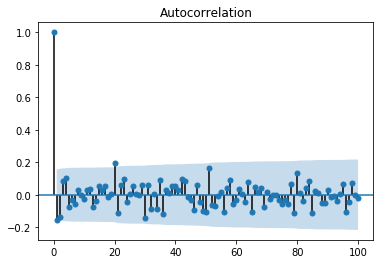

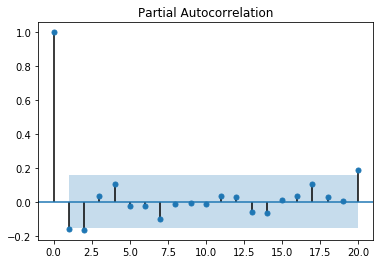

In [98]:
plot_acf(somedata,lags=100)
plot_pacf(somedata,lags=20)
plt.show()